# **Import Necessary Libraries** 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

from skimage.metrics import structural_similarity as ssim

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

2025-04-20 16:27:58.565144: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745166478.757987      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745166478.812408      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Load the Dataset**

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# **EDA (Exploratory Data Analysis)** 

***Some adjustments to better analyze the dataset:***

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

df = pd.DataFrame({
    'image': list(x_train.reshape(-1, 28*28)),
    'label': y_train,
    'label_name': [class_names[label] for label in y_train]
})

colors = plt.cm.tab10.colors

## **Class Distribution**  

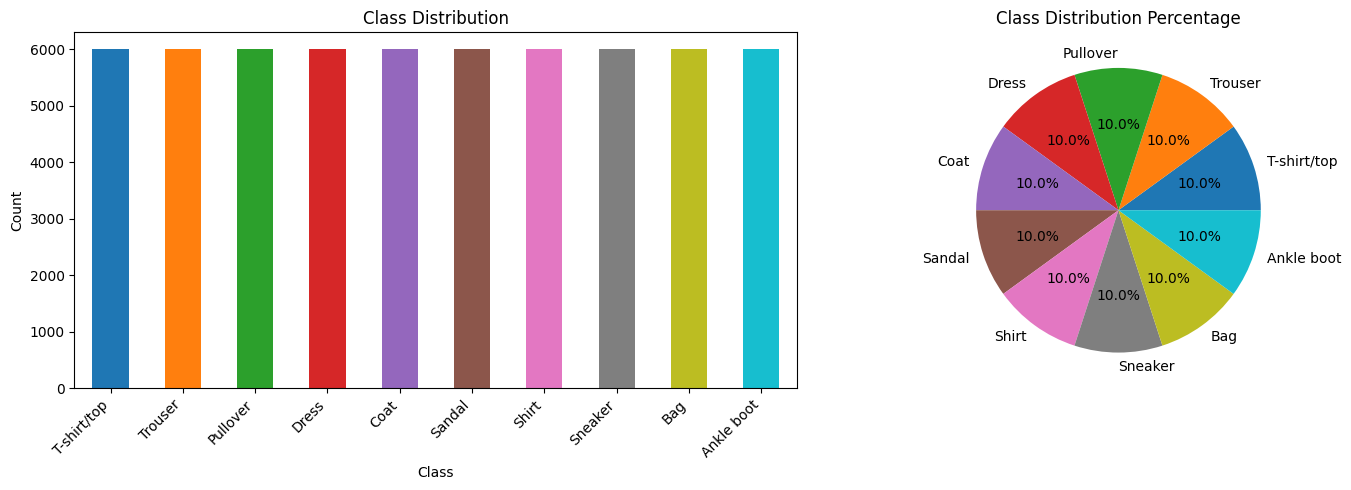

In [4]:
def class_distribution_plot(x_train, y_train):
    plt.figure(figsize=(15, 5))
    
    # Bar Plot
    plt.subplot(1, 2, 1)
    label_counts = pd.Series(y_train).value_counts().sort_index()
    label_counts.plot(kind='bar', color=colors)
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(10), class_names, rotation=45, ha='right')
    
    # Pie Chart
    plt.subplot(1, 2, 2)
    plt.pie(label_counts, labels=class_names, autopct='%1.1f%%')
    plt.title('Class Distribution Percentage')
    
    plt.tight_layout()
    plt.show()

class_distribution_plot(x_train, y_train)

## **Average Pixel Intensity and Pixel Intensity Distribution**  

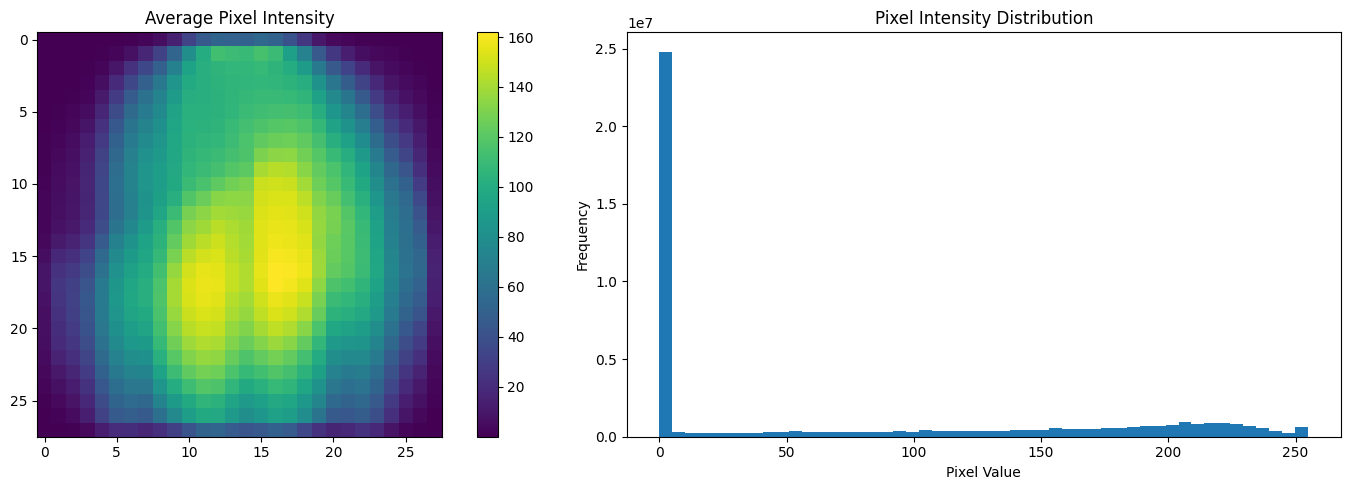

In [5]:
def pixel_intensity_analysis(x_train):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    pixel_means = x_train.reshape(-1, 28*28).mean(axis=0)
    plt.imshow(pixel_means.reshape(28, 28), cmap='viridis')
    plt.title('Average Pixel Intensity')
    plt.colorbar()
    
    plt.subplot(1, 2, 2)
    plt.hist(x_train.flatten(), bins=50)
    plt.title('Pixel Intensity Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()


pixel_intensity_analysis(x_train)

##  **Pixel Intensity by Class**

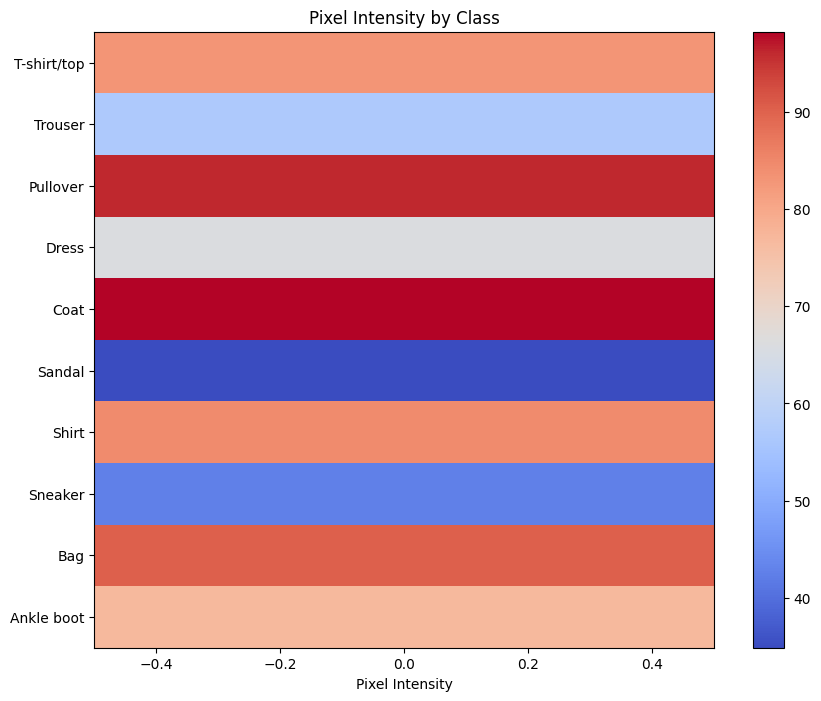


Pixel Intensity by Class:
T-shirt/top: 83.0300
Trouser: 56.8409
Pullover: 96.0588
Dress: 66.0189
Coat: 98.2580
Sandal: 34.8675
Shirt: 84.6051
Sneaker: 42.7621
Bag: 90.1572
Ankle boot: 76.8051


In [6]:
def pixel_intensity_correlation(x_train, y_train):
    plt.figure(figsize=(10, 8))
    
    class_pixel_means = [x_train[y_train == i].mean() for i in range(10)]
    
    correlation_matrix = np.array(class_pixel_means).reshape(10, 1)
    
    plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
    plt.colorbar()
    plt.title('Pixel Intensity by Class')
    plt.yticks(range(10), class_names)
    plt.xlabel('Pixel Intensity')
    plt.show()

    print("\nPixel Intensity by Class:")
    for i, (name, mean) in enumerate(zip(class_names, class_pixel_means)):
        print(f"{name}: {mean:.4f}")

pixel_intensity_correlation(x_train, y_train)

##  **Pixel Distribution**

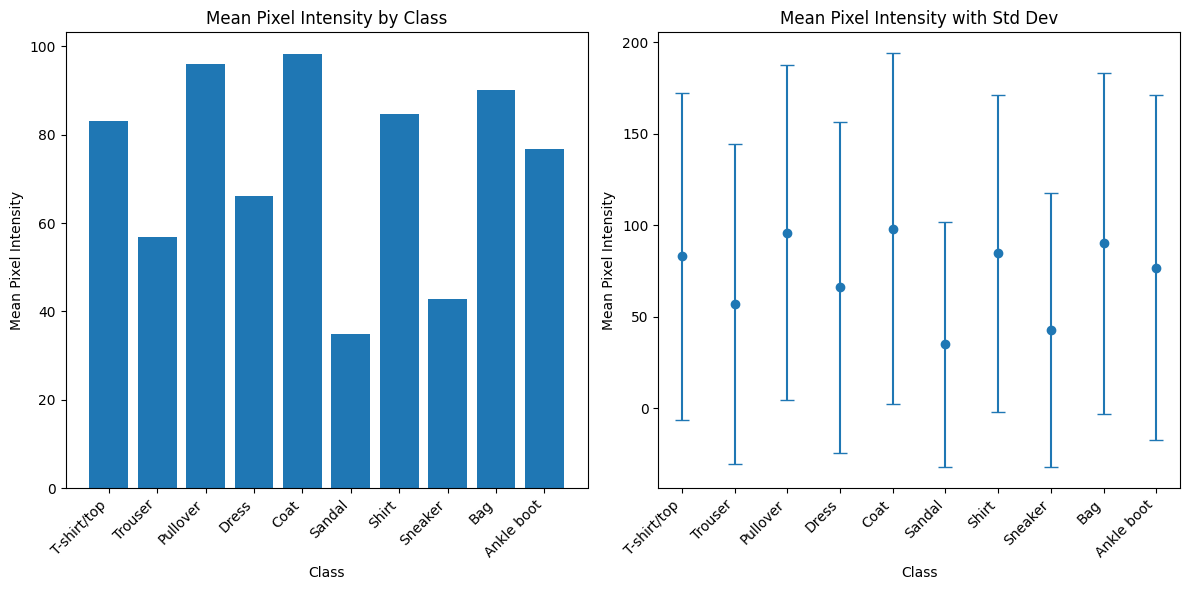


Pixel Intensity Statistics by Class:
      class      mean       std  min  max
T-shirt/top 83.029980 89.438480    0  255
    Trouser 56.840855 87.600263    0  255
   Pullover 96.058763 91.463466    0  255
      Dress 66.018909 90.326001    0  255
       Coat 98.258006 95.959524    0  255
     Sandal 34.867547 67.092563    0  255
      Shirt 84.605120 86.516051    0  255
    Sneaker 42.762072 75.170573    0  255
        Bag 90.157153 93.144150    0  255
 Ankle boot 76.805118 94.485883    0  255


In [7]:
def pixel_intensity_correlation(x_train, y_train):
    class_stats = []
    for i in range(10):
        class_images = x_train[y_train == i]
        class_stats.append({
            'class': class_names[i],
            'mean': class_images.mean(),
            'std': class_images.std(),
            'min': class_images.min(),
            'max': class_images.max()
        })
    
    df_stats = pd.DataFrame(class_stats)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.bar(df_stats['class'], df_stats['mean'])
    plt.title('Mean Pixel Intensity by Class')
    plt.xlabel('Class')
    plt.ylabel('Mean Pixel Intensity')
    plt.xticks(rotation=45, ha='right')
    
    plt.subplot(1, 2, 2)
    plt.errorbar(df_stats['class'], df_stats['mean'], 
                 yerr=df_stats['std'], 
                 fmt='o', capsize=5)
    plt.title('Mean Pixel Intensity with Std Dev')
    plt.xlabel('Class')
    plt.ylabel('Mean Pixel Intensity')
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    print("\nPixel Intensity Statistics by Class:")
    print(df_stats.to_string(index=False))

pixel_intensity_correlation(x_train, y_train)

##  **Visualization of the First 100 Samples**

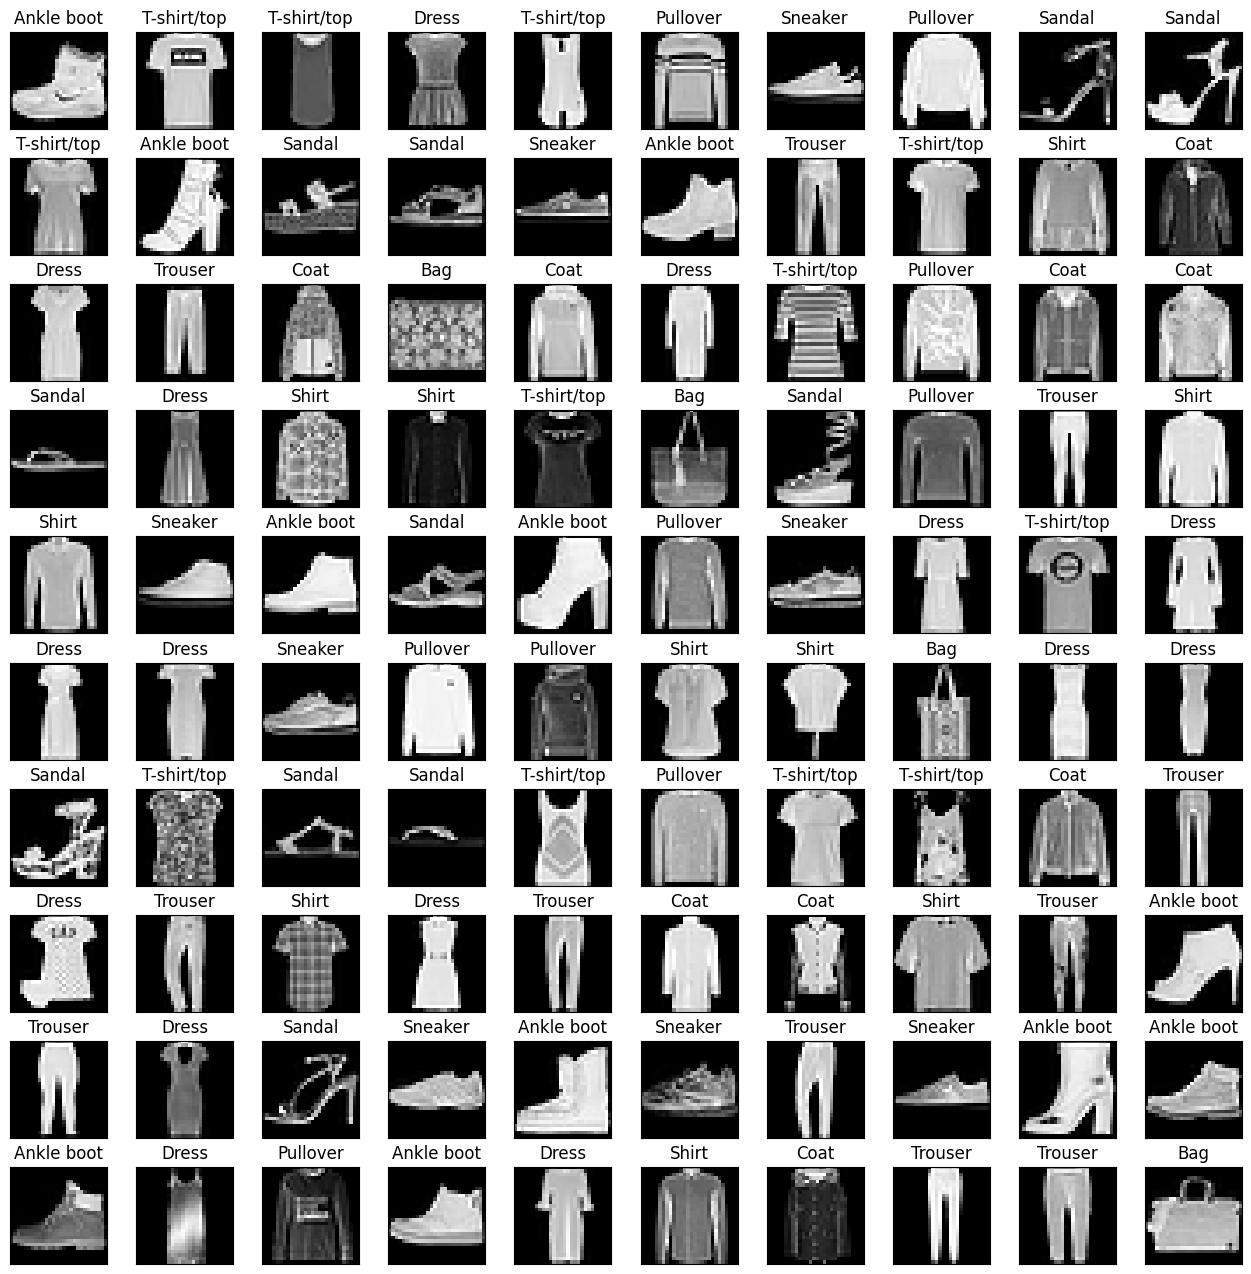

In [8]:
plt.figure(figsize=(16, 16))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i].reshape((28,28)), cmap = "gray")
    label_index = int(y_train[i])
    plt.title(class_names[label_index])
    plt.subplots_adjust(hspace=0.3)
plt.show()

##  **Visualization of 100 Random Samples**

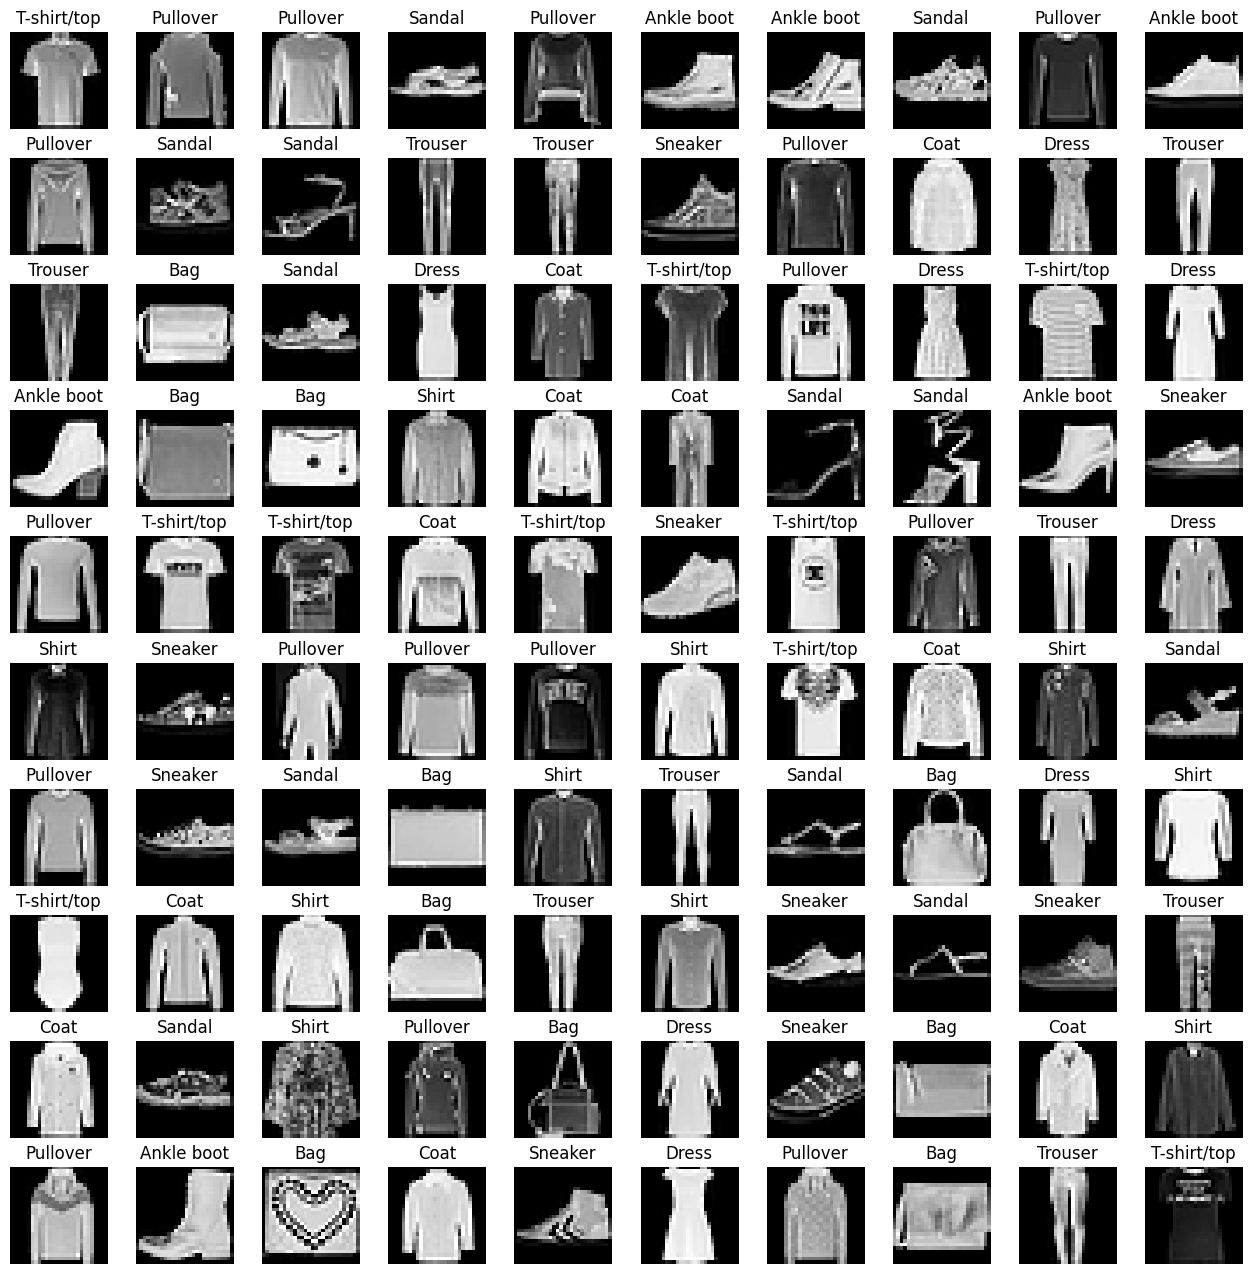

In [9]:
W_grid = 10
L_grid = 10

fig, axes = plt.subplots(L_grid, W_grid, figsize=(16, 16))
axes = axes.ravel()
n_train = len(x_train)

for i in np.arange(0, W_grid * L_grid):
    index = np.random.randint(0, n_train)
    axes[i].imshow(x_train[index].reshape((28, 28)), cmap='gray')
    labelindex = int(y_train[index])
    axes[i].set_title(class_names[labelindex])
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.3)
plt.show()

##  **Visualization of Images with Pixel Values**

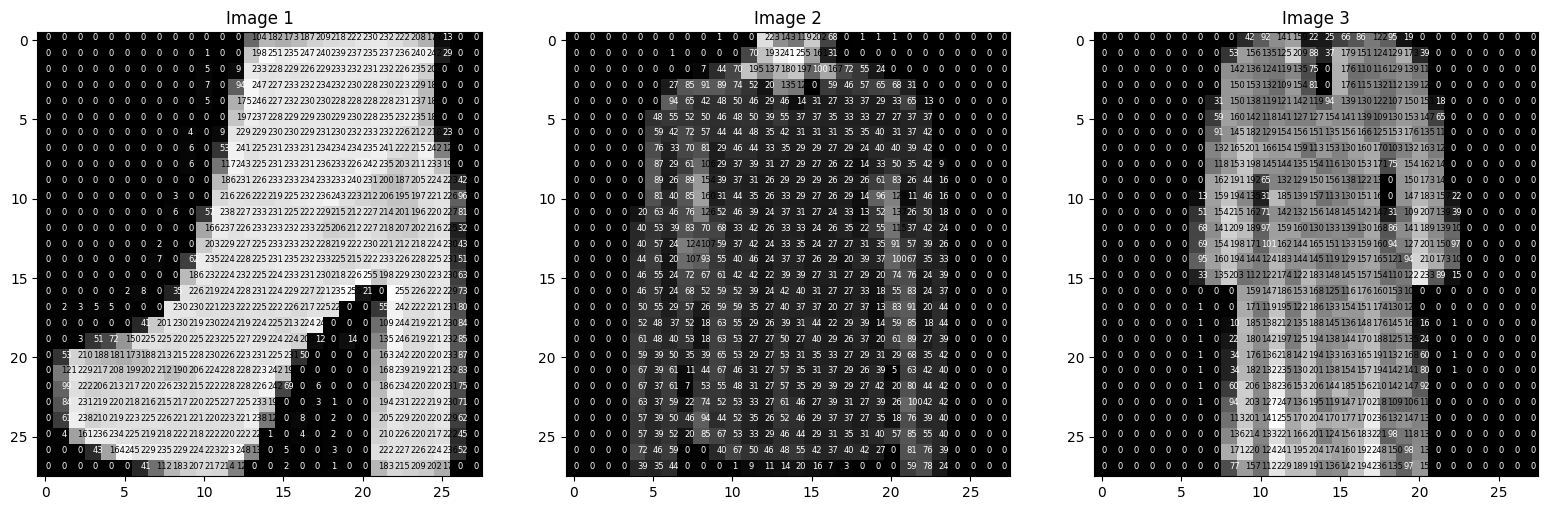

In [10]:
def pixel_visualize_multiple(images, num_images=3):
    if isinstance(images, np.ndarray):
        random_indices = np.random.choice(images.shape[0], num_images, replace=False)
        selected_images = images[random_indices]
    else:
        selected_images = images[:num_images]
    
    fig, axes = plt.subplots(1, num_images, figsize=(16, 5))
    
    for i, img in enumerate(selected_images):
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(f'Image {i+1}')
        
        width, height = img.shape
        threshold = img.max()/2.5
        
        for x in range(width):
            for y in range(height):
                axes[i].annotate(str(round(img[x][y], 2)), 
                                 xy=(y,x), 
                                 color='white' if img[x][y] < threshold else 'black',
                                 fontsize=6)
    
    plt.tight_layout()
    plt.show()

pixel_visualize_multiple(x_train)

# **Preprocessing**

##  **Scaling (Min-Max Scaling)**

***It is to enable machine learning algorithms to work more effectively and faster by bringing data at different scales into the same range (usually [0, 1]).***

In [11]:
x_train = x_train.astype("float32")/255.0
x_test = x_test.astype("float32")/255.0

In [12]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


##  **Reshaping**

In [13]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [14]:
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


# **Autoencoder Model Building**

##  **Encoded**

In [15]:
input_dim = x_train.shape[1]
encoding_dim = 64

In [16]:
input_dim

784

In [17]:
input_image = Input(shape=(input_dim,))
encoded = Dense(256, activation="relu", kernel_regularizer=l2(0.001))(input_image)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.3)(encoded)

encoded = Dense(128, activation="relu", kernel_regularizer=l2(0.001))(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.3)(encoded)

encoded = Dense(encoding_dim, activation="relu")(encoded)

I0000 00:00:1745166514.587013      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


##  **Decoded**

In [18]:
decoded = Dense(128, activation="relu", kernel_regularizer=l2(0.001))(encoded)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.3)(decoded)

decoded = Dense(256, activation="relu", kernel_regularizer=l2(0.001))(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.3)(decoded)

decoded = Dense(input_dim, activation="sigmoid")(decoded)

##  **Autoencoder**

In [19]:
autoencoder = Model(input_image, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy")

In [20]:
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 784)                 │         201,488 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 488,016 (1.86 MB)

 Trainable params: 486,480 (1.86 MB)

 Non-trainable params: 1,536 (6.00 KB)

##  **EarlyStopping**

In [21]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=20, 
    restore_best_weights=True
)

In [22]:
history = autoencoder.fit(
    x_train, x_train, 
    epochs=200,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200


I0000 00:00:1745166521.830465      64 service.cc:148] XLA service 0x7e312c003f10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745166521.831246      64 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745166522.359362      64 cuda_dnn.cc:529] Loaded cuDNN version 90300


 75/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5480

I0000 00:00:1745166525.388607      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 1.3622 - val_loss: 0.8624
Epoch 2/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7851 - val_loss: 0.5289
Epoch 3/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5033 - val_loss: 0.4047
Epoch 4/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4053 - val_loss: 0.3592
Epoch 5/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3656 - val_loss: 0.3374
Epoch 6/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3472 - val_loss: 0.3255
Epoch 7/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3364 - val_loss: 0.3176
Epoch 8/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3298 - val_loss: 0.3123
Epoch 9/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3258 - val_loss: 0.3098
Epoch 10/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3222 - val_loss: 0.3074
Epoch 11/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3197 - val_loss: 0.3053
Epoch 12/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/st

# **Model Results**

##  **Define Encoder and Create Decoder**

In [23]:
def create_decoder(autoencoder):
    # Print all layers for debugging
    print("Current layers:")
    for layer in autoencoder.layers:
        print(layer.name)
    
    # Separate encoder and decoder layers
    all_layers = autoencoder.layers
    
    # Find encoder layers (typically first half)
    mid_point = len(all_layers) // 2
    
    # Select decoder layers
    decoder_layers = all_layers[mid_point:]
    
    # Create decoder model
    encoded_input = Input(shape=(encoding_dim,))
    x = encoded_input
    

    for layer in decoder_layers:
        try:
            x = layer(x)
        except Exception as e:
            print(f"Layer skipped: {layer.name}, Error: {e}")
    
    decoder = Model(encoded_input, x)
    return decoder

# Define Encoder
encoder = Model(input_image, encoded)

# Create Decoder
decoder = create_decoder(autoencoder)

Current layers:
input_layer
dense
batch_normalization
dropout
dense_1
batch_normalization_1
dropout_1
dense_2
dense_3
batch_normalization_2
dropout_2
dense_4
batch_normalization_3
dropout_3
dense_5
Layer skipped: dense_2, Error: Input 0 of layer "dense_2" is incompatible with the layer: expected axis -1 of input shape to have value 128, but received input with shape (None, 64)


##  **Visualization of Encoded and Decoded (Reconstructed) Images**

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


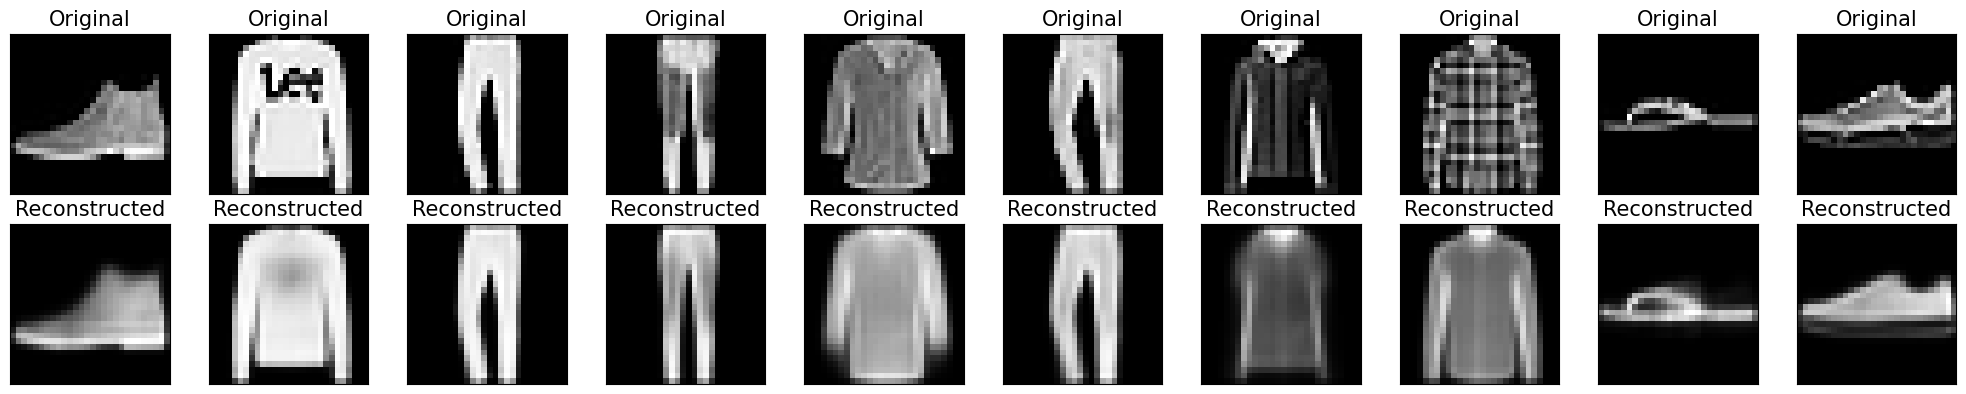

In [24]:
# Encode and decode images
encoded_images = encoder.predict(x_test)
decoded_images = decoder.predict(encoded_images)

# Visualization
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    plt.title("Original", fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_images[i].reshape(28, 28), cmap="gray")
    plt.title("Reconstructed", fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

##  **Calculate SSIM**

In [25]:
# SSIM calculation
def compute_ssim(original, reconstructed):
    original = original.reshape(28, 28)
    reconstructed = reconstructed.reshape(28, 28)
    return ssim(original, reconstructed, data_range=1)

ssim_score = []
for i in range(len(x_test)):
    original_img = x_test[i]
    reconstructed_img = decoded_images[i]
    score = compute_ssim(original_img, reconstructed_img)
    ssim_score.append(score)

average_ssim = np.mean(ssim_score)
print("Average SSIM: ", average_ssim)

Average SSIM:  0.7072192160317707


##  **Detailed SSIM Analysis**

In [26]:
# Detailed SSIM Analysis
ssim_score = []
for i in range(len(x_test)):
    original_img = x_test[i]
    reconstructed_img = decoded_images[i]
    score = compute_ssim(original_img, reconstructed_img)
    ssim_score.append(score)

# SSIM Statistics
average_ssim = np.mean(ssim_score)
median_ssim = np.median(ssim_score)
std_ssim = np.std(ssim_score)
min_ssim = np.min(ssim_score)
max_ssim = np.max(ssim_score)

print("SSIM Analysis:")
print(f"Average SSIM: {average_ssim:.4f}")
print(f"Median SSIM: {median_ssim:.4f}")
print(f"SSIM Standard Deviation: {std_ssim:.4f}")
print(f"Minimum SSIM: {min_ssim:.4f}")
print(f"Maximum SSIM: {max_ssim:.4f}")

SSIM Analysis:
Average SSIM: 0.7072
Median SSIM: 0.7252
SSIM Standard Deviation: 0.1422
Minimum SSIM: 0.1180
Maximum SSIM: 0.9857


##  **Visualization of SSIM Analysis**

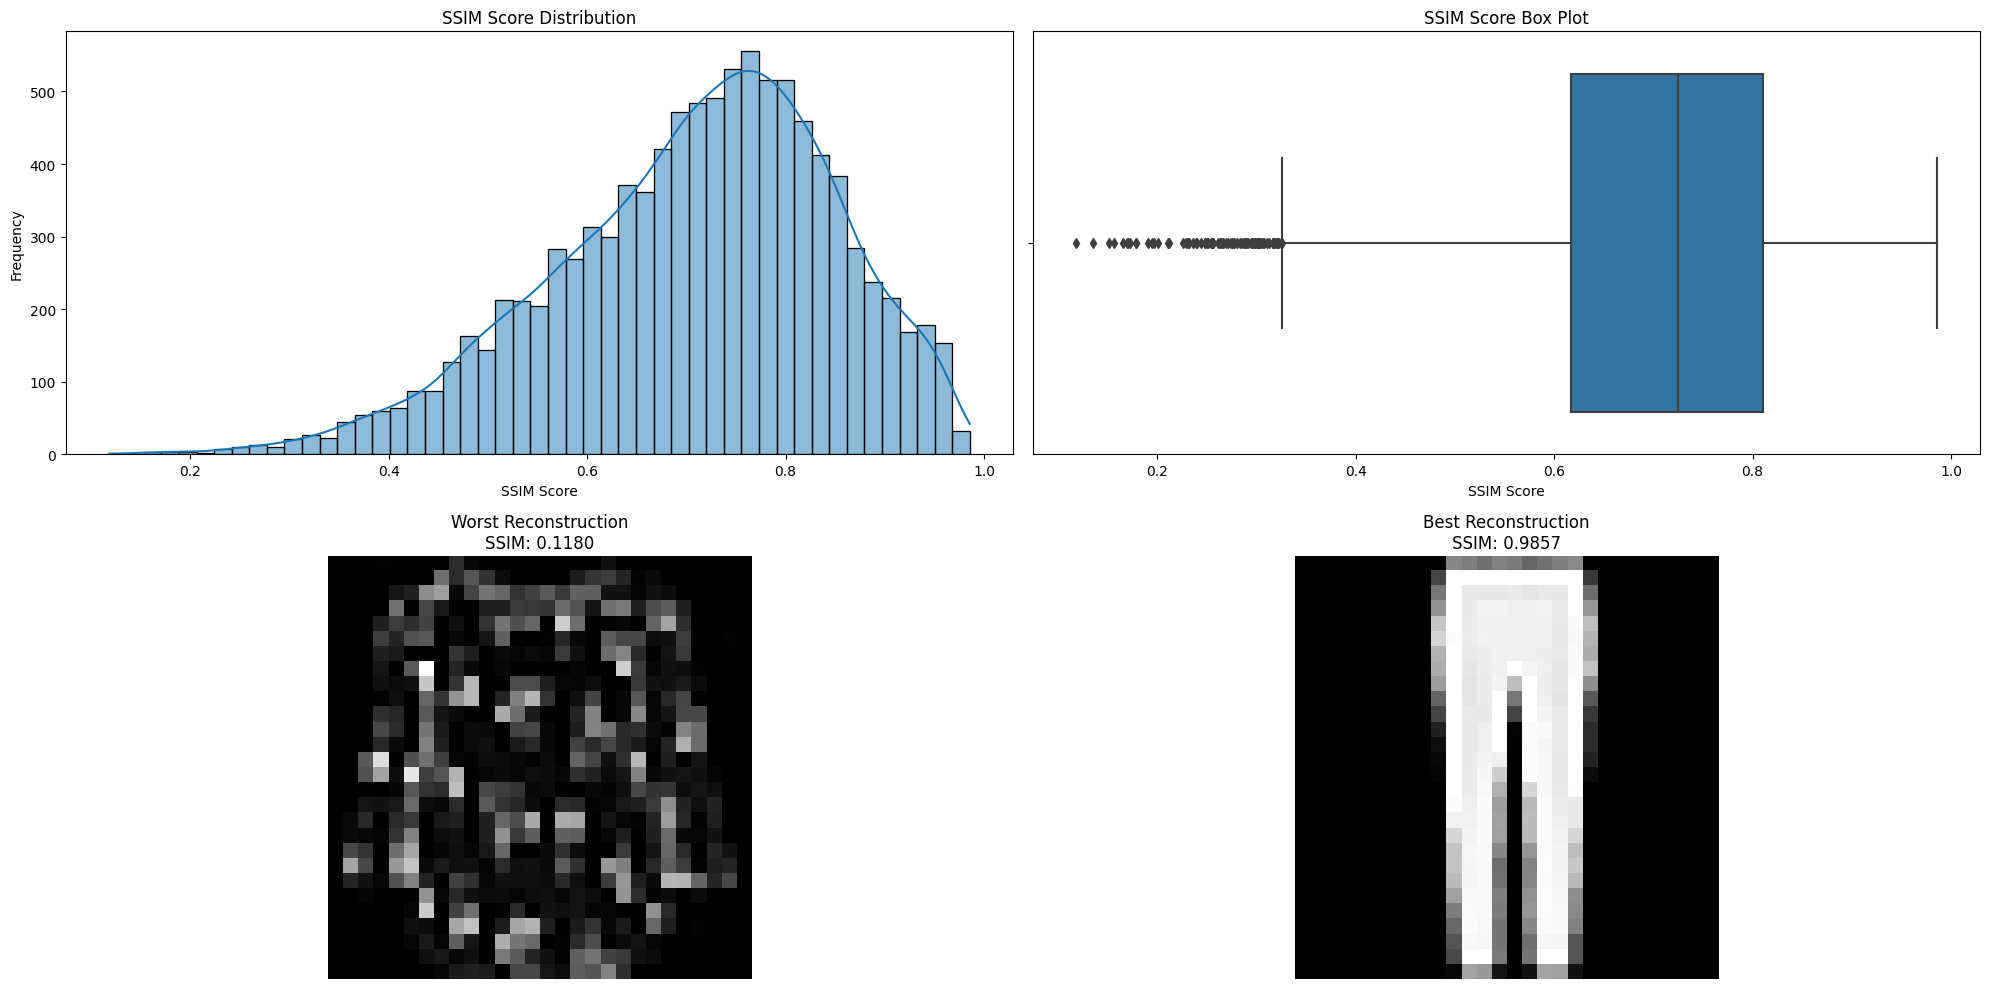

In [27]:
# Visualizations
plt.figure(figsize=(20, 10))

# SSIM Distribution Plot
plt.subplot(2, 2, 1)
sns.histplot(ssim_score, kde=True)
plt.title('SSIM Score Distribution')
plt.xlabel('SSIM Score')
plt.ylabel('Frequency')

# SSIM Box Plot
plt.subplot(2, 2, 2)
sns.boxplot(x=ssim_score)
plt.title('SSIM Score Box Plot')
plt.xlabel('SSIM Score')

# Best and Worst Reconstructions
plt.subplot(2, 2, 3)
# Image with lowest SSIM score
worst_idx = np.argmin(ssim_score)
plt.imshow(x_test[worst_idx].reshape(28, 28), cmap='gray')
plt.title(f'Worst Reconstruction\nSSIM: {ssim_score[worst_idx]:.4f}')
plt.axis('off')

plt.subplot(2, 2, 4)
# Image with highest SSIM score
best_idx = np.argmax(ssim_score)
plt.imshow(x_test[best_idx].reshape(28, 28), cmap='gray')
plt.title(f'Best Reconstruction\nSSIM: {ssim_score[best_idx]:.4f}')
plt.axis('off')

plt.tight_layout()
plt.show()

##  **Reconstruction Analysis**

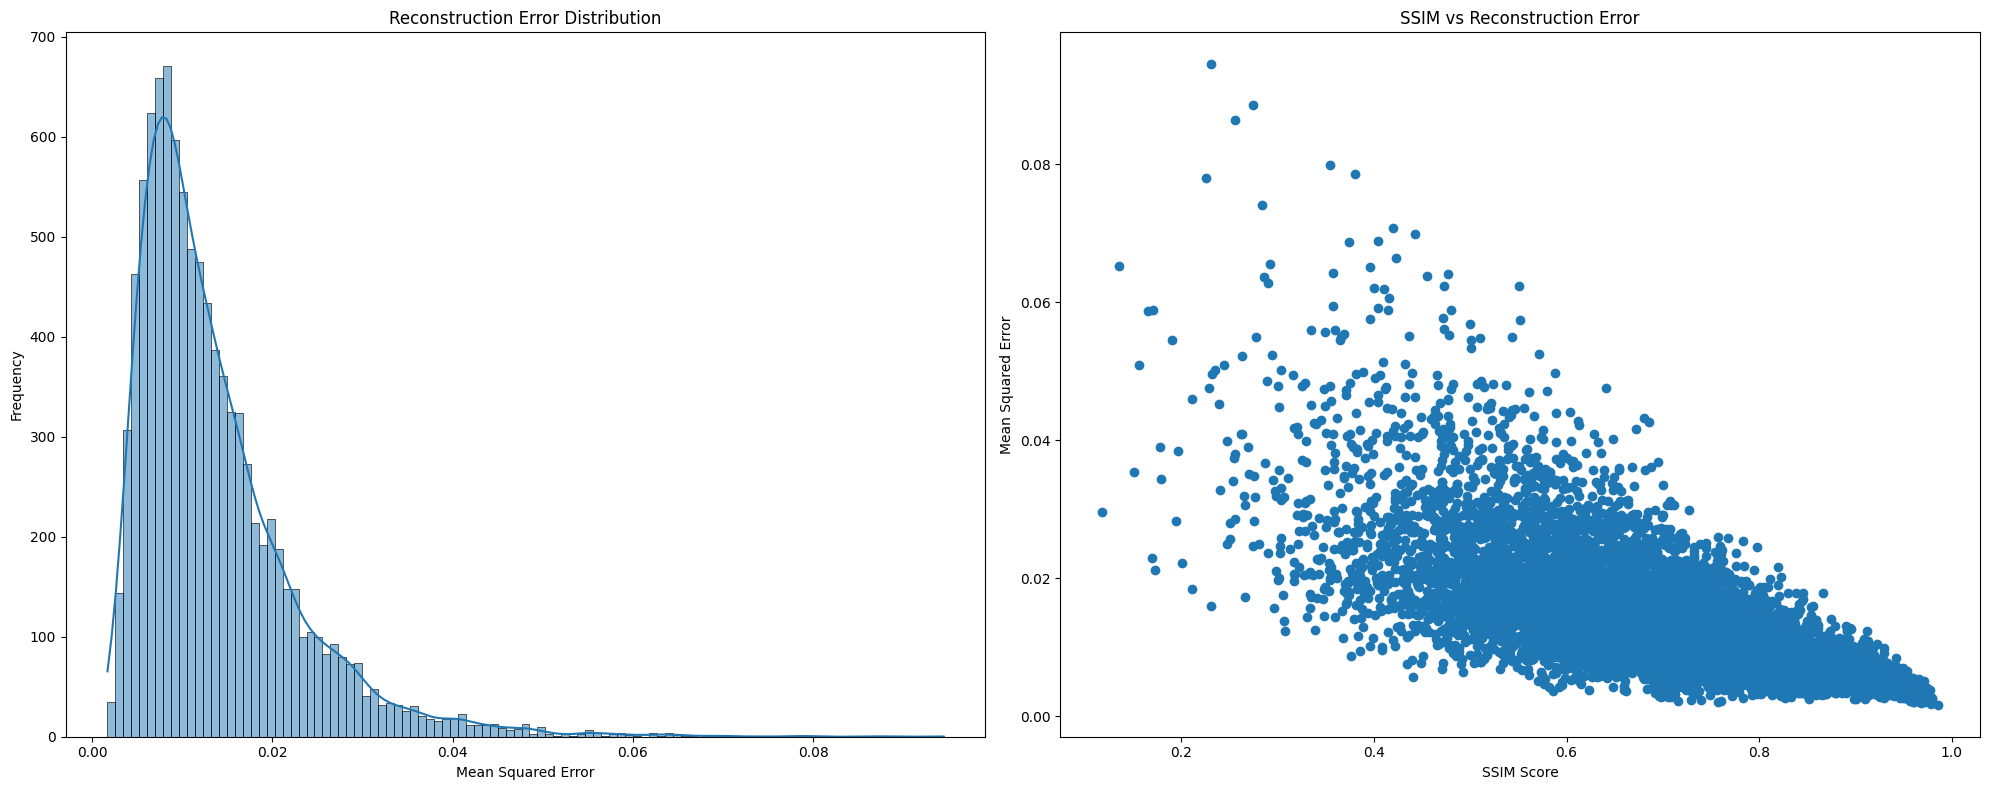

In [28]:
# Reconstruction Error Analysis
reconstruction_errors = np.mean(np.square(x_test - decoded_images), axis=1)

plt.figure(figsize=(20, 8))

# Reconstruction Error Distribution
plt.subplot(1, 2, 1)
sns.histplot(reconstruction_errors, kde=True)
plt.title('Reconstruction Error Distribution')
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')

# SSIM vs Reconstruction Error
plt.subplot(1, 2, 2)
plt.scatter(ssim_score, reconstruction_errors)
plt.title('SSIM vs Reconstruction Error')
plt.xlabel('SSIM Score')
plt.ylabel('Mean Squared Error')

plt.tight_layout()
plt.show()

##  **First 100 Encoded Image Representations and Histogram**

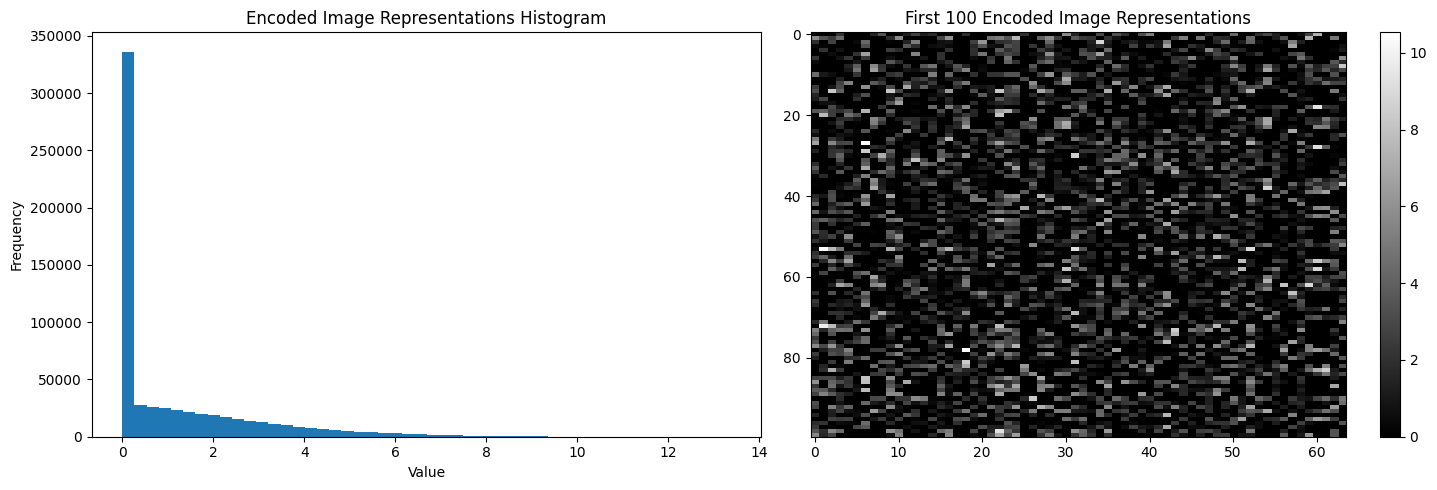

In [29]:
# Encoded Image Representations
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(encoded_images.flatten(), bins=50)
plt.title('Encoded Image Representations Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.imshow(encoded_images[:100], aspect='auto', cmap='gray')
plt.title('First 100 Encoded Image Representations')
plt.colorbar()

plt.tight_layout()
plt.show()

## **Encoded Image Representations Box Plot**

Text(0.5, 1.0, 'Encoded Image Representations Box Plot')

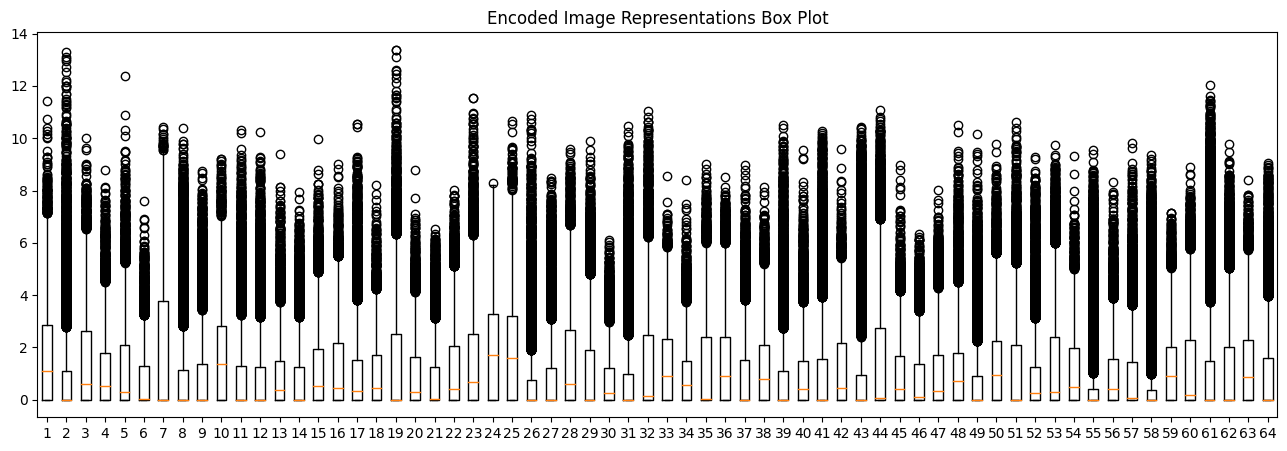

In [30]:
plt.figure(figsize=(16,5))
plt.boxplot(encoded_images)
plt.title('Encoded Image Representations Box Plot')

##  **Reconstruction Error Analysis**

In [31]:
print("Reconstruction Error Analysis:")
print(f"Mean Error: {np.mean(reconstruction_errors):.4f}")
print(f"Median Error: {np.median(reconstruction_errors):.4f}")
print(f"Standard Deviation: {np.std(reconstruction_errors):.4f}")
print(f"Minimum Error: {np.min(reconstruction_errors):.4f}")
print(f"Maximum Error: {np.max(reconstruction_errors):.4f}")

Reconstruction Error Analysis:
Mean Error: 0.0136
Median Error: 0.0112
Standard Deviation: 0.0089
Minimum Error: 0.0017
Maximum Error: 0.0945


## **Visualization of Best Reconstruction**

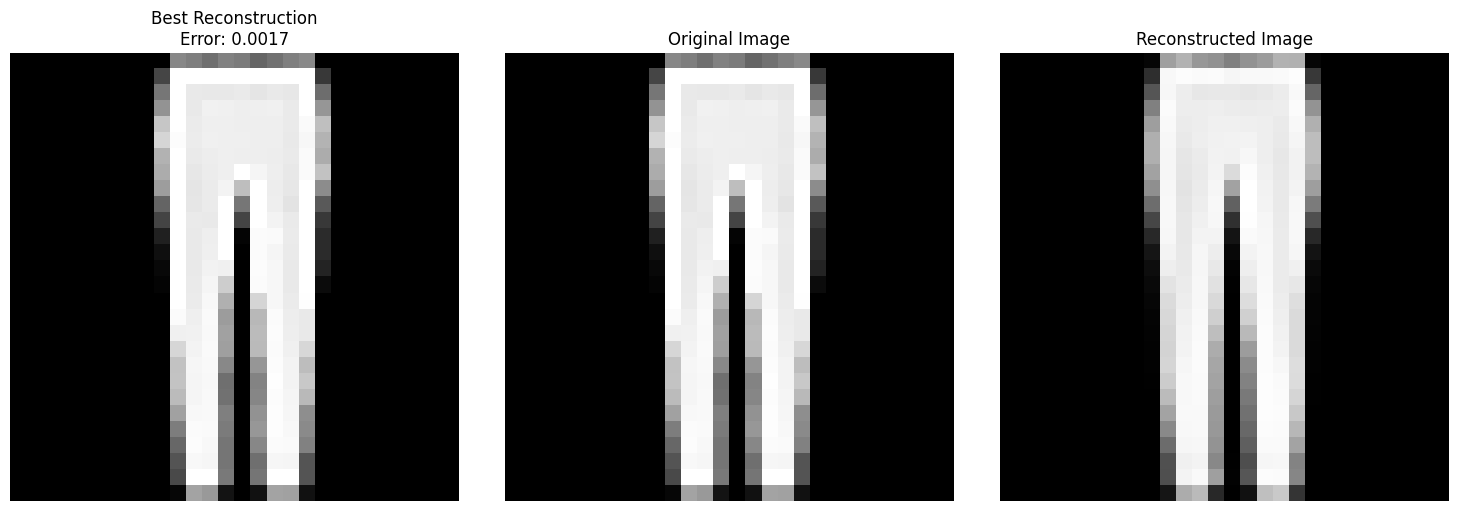

In [32]:
plt.figure(figsize=(15, 5))

best_idx = np.argmin(reconstruction_errors)
plt.subplot(1, 3, 1)
plt.imshow(x_test[best_idx].reshape(28, 28), cmap='gray')
plt.title(f'Best Reconstruction\nError: {reconstruction_errors[best_idx]:.4f}')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(x_test[best_idx].reshape(28, 28), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(decoded_images[best_idx].reshape(28, 28), cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

plt.tight_layout()
plt.show()

##  **Visualization of Worst Reconstruction**

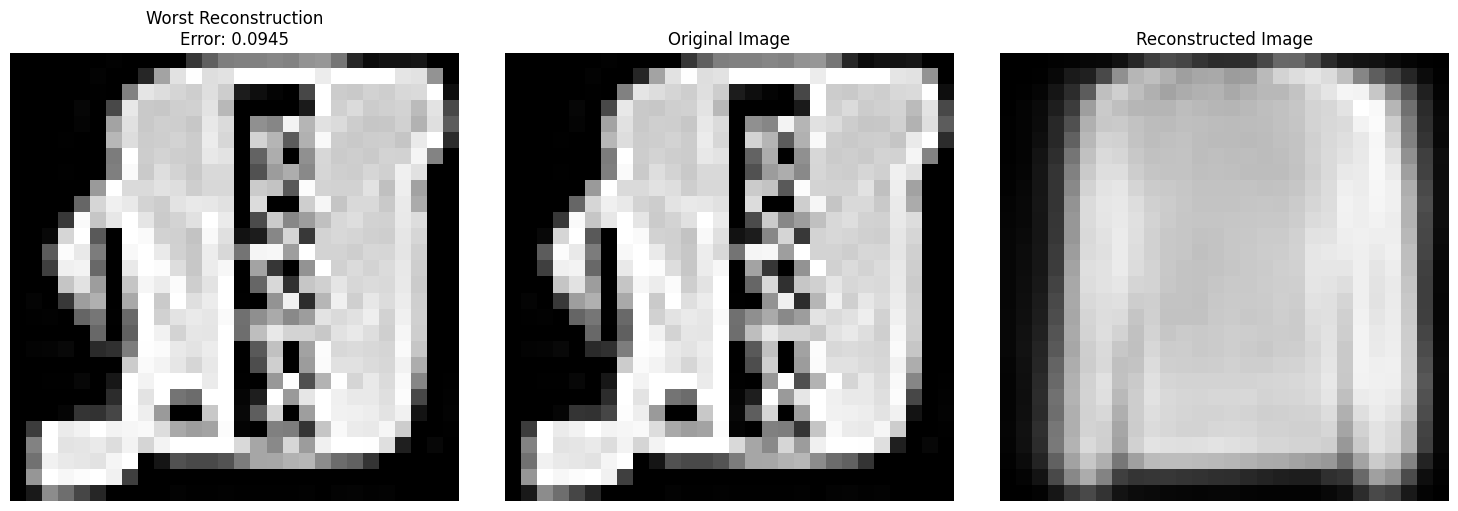

In [33]:
plt.figure(figsize=(15, 5))

worst_idx = np.argmax(reconstruction_errors)
plt.subplot(1, 3, 1)
plt.imshow(x_test[worst_idx].reshape(28, 28), cmap='gray')
plt.title(f'Worst Reconstruction\nError: {reconstruction_errors[worst_idx]:.4f}')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(x_test[worst_idx].reshape(28, 28), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(decoded_images[worst_idx].reshape(28, 28), cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

plt.tight_layout()
plt.show()

##  **Visualization of Best and Worst 5 Reconstruction**

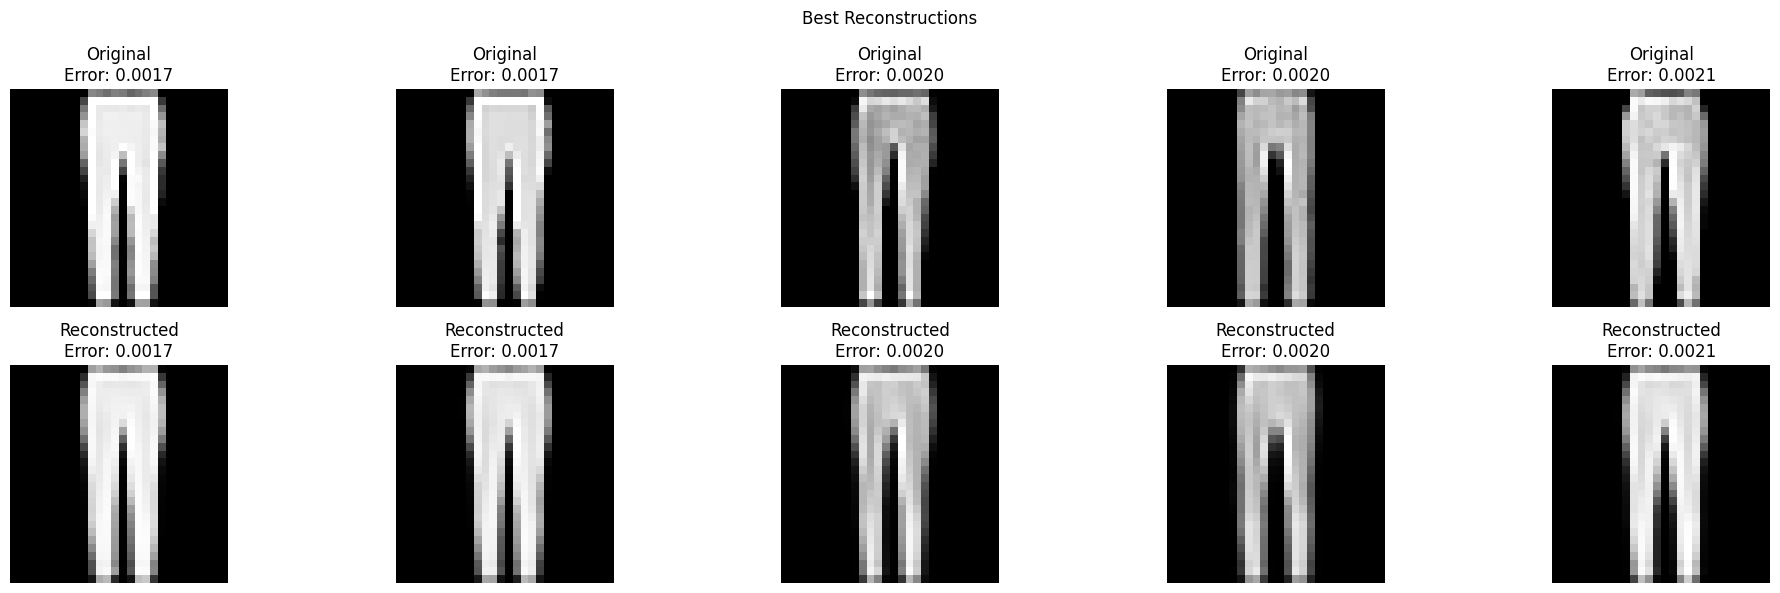

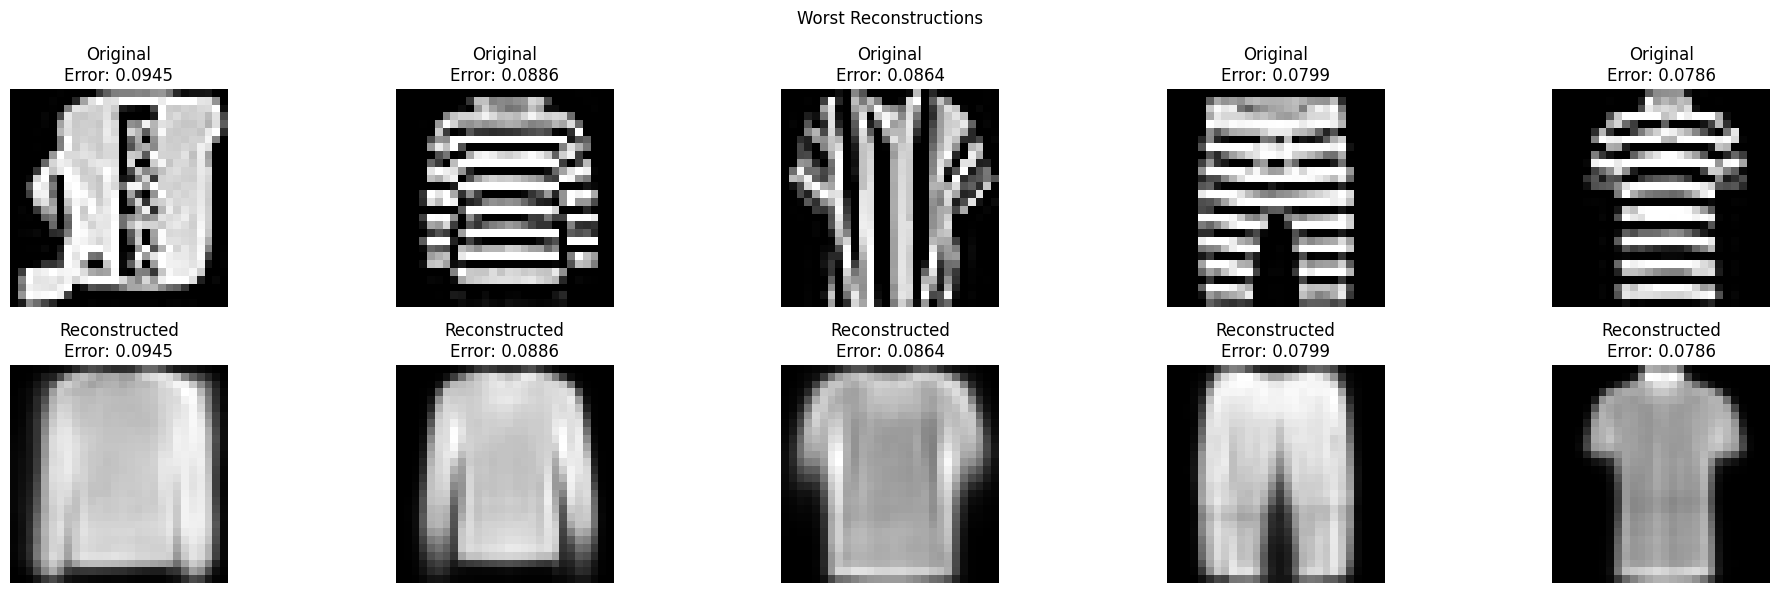

In [34]:
plt.figure(figsize=(20, 6))

best_indices = np.argsort(reconstruction_errors)[:5]
for i, idx in enumerate(best_indices):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Original\nError: {reconstruction_errors[idx]:.4f}')
    plt.axis('off')
    
    plt.subplot(2, 5, i+6)
    plt.imshow(decoded_images[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Reconstructed\nError: {reconstruction_errors[idx]:.4f}')
    plt.axis('off')

plt.suptitle('Best Reconstructions')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 6))
worst_indices = np.argsort(reconstruction_errors)[-5:][::-1]
for i, idx in enumerate(worst_indices):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Original\nError: {reconstruction_errors[idx]:.4f}')
    plt.axis('off')
    
    plt.subplot(2, 5, i+6)
    plt.imshow(decoded_images[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Reconstructed\nError: {reconstruction_errors[idx]:.4f}')
    plt.axis('off')

plt.suptitle('Worst Reconstructions')
plt.tight_layout()
plt.show()